# Dataset Surtur

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500


import numpy as np
from glob import glob as globlin
from bs4 import BeautifulSoup
import re
# from urlextract import URLExtract
import statistics
import os
import csv
#import onemillion
import socket
import textwrap

import io
from imageio import imread

#import geoip2.database

from tqdm import tqdm
tqdm.pandas()

import signal
from contextlib import contextmanager

from xgboost import XGBClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import cv2
import base64

import torch

from transformers import AutoTokenizer, AutoModel, pipeline
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel


@contextmanager
def timeout(time):
    # Register a function to raise a TimeoutError on the signal.
    signal.signal(signal.SIGALRM, raise_timeout)
    # Schedule the signal to be sent after ``time``.
    signal.alarm(time)

    try:
        yield
    except TimeoutError:
        return 'timeout error'
    finally:
        # Unregister the signal so it won't be triggered
        # if the timeout is not reached.
        signal.signal(signal.SIGALRM, signal.SIG_IGN)


def raise_timeout(signum, frame):
    raise TimeoutError

## Reading New Data

In [3]:
def read_data(main_path):
    """reading the benign samples"""
    dataframe_array = []
    benign_data_paths = globlin(main_path)
    for path in benign_data_paths:
        dataframe_array.append(pd.read_csv(path))
        #print(pd.read_csv(path).columns)
    return pd.concat(dataframe_array)

In [ ]:
dataset_surtur = read_data('./data_construction/4 - final_data/*.csv').drop(columns=['Unnamed: 0.1'])
df_mal_sup = read_data('./data_construction/supp_malicious_1.csv')

In [ ]:
df_mal_sup = df_mal_sup.drop(columns=['Label'])

In [ ]:
dataset_surtur = dataset_surtur.drop(columns=['status', 'https.1'])

In [ ]:
df_mal_sup.columns = ['url', 'has_IP_in_url', 'number_subdomains', 'hostname',
       'length_hostname', 'ratio_digits_url', 'having_@_in_url',
       'ratio_digits_hostname', 'number_underscores', 'tld', 'url_len',
       'https', 'who_is', 'content', 'label']

df_mal_sup.columns

In [ ]:
dataset_surtur = pd.concat([dataset_surtur, df_mal_sup], axis=0, sort=False).drop_duplicates()
dataset_surtur.head()

In [ ]:
dataset_surtur['label'].value_counts()

## Extracting JS

In [ ]:
def get_js(content, supp=False):
    tags_of_interest = [
        '<script type="text/javascript">', 
        '<script>'
    ]
    
    soup = BeautifulSoup(content, 'html.parser')
    js = soup.find_all('script')
    complete_js = ''
    for tag in js:
        for tag_int in tags_of_interest:
            if tag_int in str(tag):
                complete_js += str(tag).replace(tag_int, '').replace(
                    '</script>', '')
    return complete_js.encode('utf-8')

In [ ]:
dataset_surtur['js'] = dataset_surtur['content'].progress_apply(lambda content: get_js(str(content)))

## JS Length

In [ ]:
dataset_surtur['js_len'] = dataset_surtur['js'].progress_apply(lambda js: len(js))

In [ ]:
ex_string_thing = dataset_surtur[dataset_surtur['js_len']==0].iloc[1]['content']

## Counting Script tag references in html page 

In [ ]:
def script_references(js):
    return js.count('<script')/2

In [ ]:
dataset_surtur['js_ref'] = dataset_surtur['content'].progress_apply(
    lambda content: script_references(str(content)))

## Getting array lengths from JS 

In [ ]:
def get_max_array_length(js):
    array_lengths = re.findall('\(([^\)]+)\)', js)
    if array_lengths == []:
        return 0
    return max([len(i) for i in array_lengths])

def get_avg_array_length(js):
    array_lengths = re.findall('\(([^\)]+)\)', js)
    if array_lengths == []:
        return 0
    return statistics.mean([len(i) for i in array_lengths])

In [ ]:
dataset_surtur['js_array_len_avg'] = dataset_surtur['js'].progress_apply(
    lambda js: get_avg_array_length(str(js)))
dataset_surtur['js_array_len_max'] = dataset_surtur['js'].progress_apply(
    lambda js: get_max_array_length(str(js)))

## Content Length

In [ ]:
dataset_surtur['content_len'] = dataset_surtur['content'].progress_apply(
    lambda x: len(str(x)))

## Number of Function calls

In [ ]:
dataset_surtur['js'][1]

In [ ]:
def get_func_calls(js):
    full_paren = len(re.findall("\(([^\)]+)\)", js))
    empty_paren = len(js.split('()'))
    return full_paren + empty_paren

In [ ]:
dataset_surtur['num_js_func_calls'] = dataset_surtur['js'].progress_apply(
    lambda x: get_func_calls(str(x)))

## Suspicious Function Count

In [ ]:
def get_sus_js_function_count(js):
    function_list = [
        'setcookie', 'getcookie', 'createxmlhttprequest', 'unescape',
        'document.write', 'element.appendchild', 'dateobject.togmtstring',
        'new activexobject', 'document.createelement', 'getappname',
        'getuseragent', 'window.setinterval', 'window.settimeout',
        'location.assign', 'location.replace', 'eval()', 'string.indexof',
        'string.fromcharcode', 'charat', 'split',
        'string.charcodeat', 'document.writeln', 'document.appendchild',
        'innerhtml', 'insertAdjacentHTML', 'outerhtml', 
    ]

    split_js = js.replace('\n',' ').split(' ')
    counter = 0
    for element in split_js:
        if any(m_function in element.lower() for m_function in function_list):
            counter += 1

    return counter

In [ ]:
dataset_surtur['malicious_func_count'] = dataset_surtur['js'].progress_apply(
    lambda js: get_sus_js_function_count(str(js)))

## Get total and external URL count in content

In [ ]:
# def find_urls(string, ext_count):
#     # with timeout(1):
#     regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
#     url = re.findall(regex, string)
#     if ext_count:
#         return len(set(url))
#     return len(url)


# # Test Code
# string = 'My Profile: https://auth.geeksforgeeks.org/user/Chinmoy%20Lenka/articles in the portal of http://www.geeksforgeeks.org/'
# print("Urls: ", find_urls(string, False))

In [ ]:
def find_urls(string, ext_count):
    try:
        extractor = URLExtract()
        urls = extractor.find_urls(string)
        if ext_count: 
            return len(set(urls))
        return len(urls)
    except:
        return 10000

string_ex = 'My Profile: https://auth.geeksforgeeks.org/user/Chinmoy%20Lenka/articles in the portal of http://www.geeksforgeeks.org/'
    
print(find_urls(string_ex, False))

In [ ]:
dataset_surtur['total_url_count'] = dataset_surtur['content'].progress_apply(
    lambda js: find_urls(str(js), False)
)

In [ ]:
dataset_surtur['ext_url_count'] = dataset_surtur['content'].progress_apply(
    lambda js: find_urls(str(js), True)
)

In [ ]:
dataset_surtur.columns

## More Lexical Features

In [ ]:
dataset_surtur['num_semicolons'] = dataset_surtur['url'].progress_apply(lambda url: str(url).count(';'))
dataset_surtur['num_zeros'] = dataset_surtur['url'].progress_apply(lambda url: str(url).count('0'))
dataset_surtur['num_spaces'] = dataset_surtur['url'].progress_apply(lambda url: str(url).count('%20'))
dataset_surtur['num_hyphens'] = dataset_surtur['url'].progress_apply(lambda url: str(url).count('-'))
dataset_surtur['num_@s'] = dataset_surtur['url'].progress_apply(lambda url: str(url).count('@'))
dataset_surtur['num_queries'] = dataset_surtur['url'].progress_apply(lambda url: str(url).count('?'))
dataset_surtur['num_ampersands'] = dataset_surtur['url'].progress_apply(lambda url: str(url).count('&'))
dataset_surtur['num_equals'] = dataset_surtur['url'].progress_apply(lambda url: str(url).count('='))

## Safe Browsing API Judgement

In [ ]:
with open('./safebrowsingkey.txt') as f:
    api_key = f.read()

In [ ]:
import requests

key = 'your key here'
URL = "https://sb-ssl.google.com/safebrowsing/api/lookup?client=api&apikey={key}&appver=1.0&pver=3.0&url={url}"


def is_safe(url):
    try:
        response = requests.get(URL.format(key=api_key, url=url))
        return response.text != 'malware'
    except:
        return 'unknown'


print(is_safe('http://addonrock.ru/Debugger.js/'))  # prints False
print(is_safe('http://google.com'))  # prints True


dataset_surtur['google_is_safe'] = dataset_surtur['url'].progress_apply(lambda url: is_safe(url))

## Retrieving Domain names and their lengths

In [ ]:
dataset_surtur['domain'] = dataset_surtur['hostname'].progress_apply(
    lambda hostname: '.'.join(str(hostname).split('.')[-2:]))

In [ ]:
dataset_surtur['domain_len'] = dataset_surtur['domain'].progress_apply(lambda domain: len(domain))

## Get IP address

In [ ]:
dataset_surtur.iloc[0]['url']

In [ ]:
dataset_surtur.iloc[2]['url'].split('/')[2]

In [ ]:
socket.gethostbyname(dataset_surtur['url'].iloc[28].split('/')[2])

In [ ]:
dataset_surtur['url'].iloc[27].split('/')[2]

In [ ]:
def get_ip_url(url):
    try:
        domain = url.split('/')[2]
        return socket.gethostbyname(domain)
    except:
        return 'unknown'

dataset_surtur['ip_address'] = dataset_surtur['url'].progress_apply(
    lambda url: get_ip_url(url))

In [ ]:
dataset_surtur['ip_address'].value_counts()

In [ ]:
len(dataset_surtur[dataset_surtur['ip_address'] == 'unknown'])

## Get location of each site

In [ ]:
reader = geoip2.database.Reader('./GeoLite2-Country.mmdb')

def get_location(ip_add):
    try:
        if ip_add == 'unknown':
            return 'unknown'
        response = reader.country(ip_add)
        return response.country.name
    except Exception as msg:
        return 'unknown'

dataset_surtur['location'] = dataset_surtur['ip_address'].progress_apply(
    lambda ip_add: get_location(ip_add))

reader.close()
#df

## One hot encoding

In [ ]:
def column_adjustor(dataset_column):
    unique_values = dataset_column.unique()
    return dataset_column.progress_apply(lambda x: np.where(unique_values == x)[0][0])

In [ ]:
dataset_surtur = dataset_surtur.dropna()

In [ ]:
dataset_surtur['who_is'] = column_adjustor(dataset_surtur['who_is'])
dataset_surtur['https'] = column_adjustor(dataset_surtur['https'])
dataset_surtur['tld'] = column_adjustor(dataset_surtur['tld'])
dataset_surtur['google_is_safe'] = column_adjustor(dataset_surtur['google_is_safe'])
dataset_surtur['location'] = column_adjustor(dataset_surtur['location'])


dataset_surtur['label'] = dataset_surtur['label'].progress_apply(
    lambda label: 1 if 'bad' in label else 0)

In [ ]:
dataset_surtur

# Checkpoint 

In [2]:
# dataset_surtur.to_csv('./dataset_surtur.csv', index=False)

In [512]:
dataset_surtur = pd.read_csv('./dataset_surtur.csv')
dataset_surtur.columns

Index(['content', 'has_IP_in_url', 'having_@_in_url', 'hostname', 'https',
       'label', 'length_hostname', 'number_subdomains', 'number_underscores',
       'ratio_digits_hostname', 'ratio_digits_url', 'tld', 'url', 'url_len',
       'who_is', 'js', 'js_len', 'js_ref', 'js_array_len_avg',
       'js_array_len_max', 'content_len', 'num_js_func_calls',
       'malicious_func_count', 'total_url_count', 'ext_url_count',
       'num_semicolons', 'num_zeros', 'num_spaces', 'num_hyphens', 'num_@s',
       'num_queries', 'num_ampersands', 'num_equals', 'domain', 'domain_len',
       'google_is_safe', 'ip_address', 'location'],
      dtype='object')

In [513]:
df_surtur_alpha = pd.read_csv('./dataset_surtur_alpha.csv')
df_surtur_alpha.head()

content  has_IP_in_url  \
0  <?xml version="1.0" encoding="UTF-8"?>\n<!DOCT...            0.0   
1  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//...            0.0   
2  <html>\n<head>\n<meta content="text/html; char...            0.0   
3  <!DOCTYPE HTML>\n\n<html><!-- InstanceBegin te...            0.0   
4                            could not fetch content            0.0   

   having_@_in_url                    hostname  https  label  length_hostname  \
0              0.0    islandvolleyballclub.com      0      0             24.0   
1              0.0       www.indiosoftware.com      0      0             21.0   
2              0.0  naturalfilters.bizland.com      0      0             26.0   
3              0.0            www.rosepath.com      0      0             16.0   
4              0.0   www.plannedparrothood.com      0      0             25.0   

   number_subdomains  number_underscores  ratio_digits_hostname  \
0                0.0                 0.0                    0.0   
1                1.0                 0.0                    0.0   
2                1.0                 0.0                    0.0   
3                1.0                 0.0                    0.0   
4                1.0                 0.0                    0.0   

   ratio_digits_url  tld                                          url  \
0               0.0    0  http://islandvolleyballclub.com/venues.html   
1               0.0    0                http://www.indiosoftware.com/   
2               0.0    0  http://naturalfilters.bizland.com/aquarain/   
3               0.0    0                      http://www.rosepath.com   
4               0.0    0            http://www.plannedparrothood.com/   

   url_len  who_is                                                 js  js_len  \
0     43.0       0                                                b''       0   
1     29.0       0  b'\nfunction getCookie(c_name) { // Local func...    1103   
2     43.0       0  b'\nfunction myopen(filename,windowname,proper...     133   
3     23.0       0  b'qm_create(0,false,0,0,false,false,false,fals...      53   
4     33.0       0                                                b''       0   

   js_ref  js_array_len_avg  js_array_len_max  content_len  num_js_func_calls  \
0     0.0               0.0                 0         7813                  1   
1     0.5              17.2                69         1556                 23   
2     0.5              30.0                30        26533                  4   
3     1.5              41.0                41         6465                  2   
4     0.0               0.0                 0           23                  1   

   malicious_func_count  total_url_count  ext_url_count  num_semicolons  \
0                     0               15             14               0   
1                     4                2              2               0   
2                     0               40             28               0   
3                     0                5              5               0   
4                     0                0              0               0   

   num_zeros  num_spaces  num_hyphens  num_@s  num_queries  num_ampersands  \
0          0           0            0       0            0               0   
1          0           0            0       0            0               0   
2          0           0            0       0            0               0   
3          0           0            0       0            0               0   
4          0           0            0       0            0               0   

   num_equals                    domain  domain_len  
0           0  islandvolleyballclub.com          24  
1           0         indiosoftware.com          17  
2           0               bizland.com          11  
3           0              rosepath.com          12  
4           0     plannedparrothood.com          21

In [514]:
dataset_surtur['label'].value_counts()

0    61080
1    44405
Name: label, dtype: int64

In [515]:
len(dataset_surtur)

105485

## Loading images

In [523]:
imgs_for_org_index = globlin('./dataset_surtur_images_original_index_insert/*.png')
imgs_for_mal_separate = globlin('./dataset_surt_images_malicious/*.png')
imgs_for_ben_separate = globlin('./dataset_surtur_images_unique_index (when isolating benign)/*.png')


def get_saved_index(path):
    return int(path.split('/')[-1].replace('_0.png', '').replace('_1.png', ''))

In [517]:
try:
    pbar.close()
    pbar.close()
    pbar.close()
    pbar.close()
except:
    pass

In [10]:
df_imgs = np.zeros((len(df_surtur_alpha), 1, 1000))

pbar = tqdm(total=len(imgs_for_org_index) + len(imgs_for_ben_separate) + len(imgs_for_mal_separate)) 

def read_image(path):
    bgr_image = cv2.imread(path)
    return cv2.resize(cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB), (512, 512))

model = torch.hub.load('pytorch/vision:v0.9.0', 
                       'mobilenet_v2', 
                       pretrained=True)
    
    
for path in imgs_for_org_index:
    img_index = get_saved_index(path)
    image = read_image(path)
    image_tensor = torch.tensor(image.reshape([3, 512, 512])).unsqueeze(0).float()
    df_imgs[img_index] = model(image_tensor).detach().numpy()    
    pbar.update(1)

 45%|████▍     | 44959/100900 [5:19:52<6:36:58,  2.35it/s] 

In [11]:
df_surtur_alpha_malicious = df_surtur_alpha[df_surtur_alpha['label'] == 1].reset_index()
malicious_index_list = df_surtur_alpha_malicious['index']

for index, path in enumerate(imgs_for_mal_separate):
    img_index = get_saved_index(path)
    try:
        image = read_image(path)
        image_tensor = torch.tensor(image.reshape([3, 512, 512])).unsqueeze(0).float()   
        df_imgs[malicious_index_list[img_index]] = model(image_tensor).detach().numpy()
    except:
        pass
    pbar.update(1)
    
df_surtur_alpha_benign =  df_surtur_alpha[df_surtur_alpha['label'] == 0].reset_index()
benign_index_list = df_surtur_alpha_benign['index']

for index, path in enumerate(imgs_for_ben_separate):
    img_index = get_saved_index(path)
    try:
        image = read_image(path)
        image_tensor = torch.tensor(image.reshape([3, 512, 512])).unsqueeze(0).float()   
        df_imgs[benign_index_list[img_index]] = model(image_tensor).detach().numpy()
    except:
        pass
    pbar.update(1)

100%|██████████| 100900/100900 [11:53:53<00:00,  2.27it/s] 

In [13]:
# pd.DataFrame(np.array(df_imgs).reshape([len(df_imgs), 1000])).to_csv('img_features_2.csv', index=False)

## Get dominant colors

In [544]:
import cv2
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5)


class DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    
    def __init__(self, image, clusters=5):
        self.CLUSTERS = clusters
        self.IMAGE = image
        
    def dominantColors(self):
    
        #read image
        img = cv2.imread(self.IMAGE)
        
        #convert to rgb from bgr
        img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (512, 512))
                
        #reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        
        #save image after operations
        self.IMAGE = img
        
        #using k-means to cluster pixels
        kmeans.fit(img)
        
        #the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_
        
        #save labels
        self.LABELS = kmeans.labels_
        
        #returning after converting to integer from float
        return self.COLORS.astype(int)
    


# img = '.jpg'
clusters = 5
dc = DominantColors(imgs_for_org_index[2], clusters) 
colors = dc.dominantColors()
print(colors)
print(np.array(colors).reshape([len(colors)*len(colors[0])]).shape)

[[237 237 237]
 [ 85  46  92]
 [  0 252   0]
 [166 142 170]
 [254 254 254]]
(15,)


In [545]:
np.array(colors).reshape([len(colors)*len(colors[0])])

array([237, 237, 237,  85,  46,  92,   0, 252,   0, 166, 142, 170, 254,
       254, 254])

In [611]:
pbar.close()

In [604]:
np.append(colors[0:2], np.zeros(5-len(colors[0:2])).astype('str'))

array(['#ffffff', '0.0', '0.0', '0.0', '0.0'], dtype='<U32')

In [612]:
from dominant_color_detection import detect_colors

df_imgs = np.zeros((len(df_surtur_alpha), 5)).astype('str')
pbar2 = tqdm(total=len(imgs_for_org_index) + len(imgs_for_ben_separate) + len(imgs_for_mal_separate)) 
clusters = 5

for path in imgs_for_org_index:
    img_index = get_saved_index(path)
    colors = detect_colors(path, clusters)[0]
    if len(colors) < 5:
        colors = np.append(colors, np.zeros(5-len(colors)).astype('str'))
    df_imgs[img_index] = colors
    pbar2.update(1)
    
df_surtur_alpha_malicious = df_surtur_alpha[df_surtur_alpha['label'] == 1].reset_index()
malicious_index_list = df_surtur_alpha_malicious['index']

for index, path in enumerate(imgs_for_mal_separate):
    img_index = get_saved_index(path)
    try:
        colors = detect_colors(path, clusters)[0]
        if len(colors) < 5:
            colors = np.append(colors, np.zeros(5-len(colors)).astype('str'))
        df_imgs[malicious_index_list[img_index]] = colors
    except:
        pass
    pbar2.update(1)
    
df_surtur_alpha_benign =  df_surtur_alpha[df_surtur_alpha['label'] == 0].reset_index()
benign_index_list = df_surtur_alpha_benign['index']

for index, path in enumerate(imgs_for_ben_separate):
    img_index = get_saved_index(path)
    try:
        colors = detect_colors(path, clusters)[0]
        if len(colors) < 5:
            colors = np.append(colors, np.zeros(5-len(colors)).astype('str'))
        df_imgs[benign_index_list[img_index]] = colors
    except:
        pass
    pbar2.update(1)

100%|██████████| 100900/100900 [12:28:12<00:00,  1.91it/s] 

In [613]:
# pd.DataFrame(df_imgs).to_csv('DCD.csv', index=False)

In [642]:
DCD_feats = pd.read_csv('DCD.csv')
DCD_feats.columns = ['dcd_color_1', 'dcd_color_2', 'dcd_color_3', 'dcd_color_4', 'dcd_color_5']

In [643]:
DCD_feats.head()

dcd_color_1 dcd_color_2 dcd_color_3 dcd_color_4 dcd_color_5
0     #434442     #576154     #293125     #80ca60     #e2e2e1
1     #f1f5f7     #cbdde4     #99b7cc     #5e5f5e     #00f901
2     #000000     #fefefd     #524e4c     #d0bdb3     #9c0d0d
3     #f9f5ea     #c8cbcb     #a8a39b     #706154     #271914
4     #d1dcc6     #fcfdfd     #4196a5     #ea7e22     #545245

In [644]:
from PIL import ImageColor

def get_avg_color(hex_color):
    if hex_color=='0.0':
        return 0.0
    return sum(ImageColor.getcolor(hex_color, "RGB"))/3

In [645]:
DCD_feats['dcd_color_1'] = DCD_feats['dcd_color_1'].progress_apply(lambda color: get_avg_color(color))
DCD_feats['dcd_color_2'] = DCD_feats['dcd_color_2'].progress_apply(lambda color: get_avg_color(color))
DCD_feats['dcd_color_3'] = DCD_feats['dcd_color_3'].progress_apply(lambda color: get_avg_color(color))
DCD_feats['dcd_color_4'] = DCD_feats['dcd_color_4'].progress_apply(lambda color: get_avg_color(color))
DCD_feats['dcd_color_5'] = DCD_feats['dcd_color_5'].progress_apply(lambda color: get_avg_color(color))


100%|██████████| 105492/105492 [00:00<00:00, 197037.10it/s][A

100%|██████████| 105492/105492 [00:00<00:00, 208679.24it/s][A

100%|██████████| 105492/105492 [00:00<00:00, 214299.42it/s][A

100%|██████████| 105492/105492 [00:00<00:00, 217381.41it/s][A

100%|██████████| 105492/105492 [00:00<00:00, 219086.37it/s][A


In [649]:
DCD_feats.head()

dcd_color_1  dcd_color_2  dcd_color_3  dcd_color_4  dcd_color_5
0    67.000000    89.333333    42.333333   142.000000   225.666667
1   244.333333   217.333333   180.000000    94.333333    83.333333
2     0.000000   253.666667    78.666667   192.000000    60.666667
3   242.666667   202.000000   162.000000    97.666667    28.000000
4   209.000000   252.666667   126.666667   131.333333    78.333333

## Extracting features

In [49]:
pbar.close()

In [50]:
pbar = tqdm(total=len(df_imgs))

# model = tf.keras.applications.MobileNetV2(include_top=False, 
#                                           weights='imagenet', 
#                                           input_shape=(512, 512, 3))

model = torch.hub.load('pytorch/vision:v0.9.0', 
                       'mobilenet_v2', 
                       pretrained=True)


df_images_features = np.zeros((len(df_surtur_alpha), 1, 1000))
for index, image in enumerate(df_imgs):
    image_tensor = torch.tensor(image.reshape([3, 512, 512])).unsqueeze(0).float()     
    df_images_features[index] = model(image_tensor).detach().numpy()
    pbar.update(1)

100%|██████████| 105492/105492 [5:12:22<00:00,  5.62it/s] 

In [51]:
df_images_features.shape

(105492, 1, 1000)

In [53]:
df_images_features_to_save = df_images_features.reshape([len(df_images_features), 1000])

In [54]:
# pd.DataFrame(df_images_features_to_save).to_csv('./new_image_feats.csv', index=False)

## Checkpoint 2 - Image feature selection

In [660]:
df_img_feats = pd.read_csv('./img_features_2.csv')
df_img_feats.head()

0         1         2         3         4         5         6  \
0 -1.502026 -0.885667 -1.463794 -3.122547 -1.550751 -0.747169 -0.822824   
1 -1.267254 -0.602327 -0.911539 -2.296638 -1.324422 -0.248855 -0.317996   
2 -0.500091 -1.133124 -0.765036 -2.314270 -0.997257  0.269133 -0.754960   
3 -0.885695 -0.624981 -0.300235 -1.395928 -0.447174  0.115989  0.040323   
4 -1.544818 -1.099851 -0.491839 -2.321872 -1.206620 -0.418127 -1.012049   

          7         8         9        10        11        12        13  \
0  1.693095  0.918501 -1.368025 -1.822789 -1.235428 -1.087810 -1.838742   
1  0.749607  0.483238  0.048878 -1.689340 -1.348566 -0.307460 -1.809594   
2  0.374487  1.045287 -0.933833 -1.324002 -1.555367 -1.396901 -1.735068   
3  1.118432  1.116692 -0.943920 -1.288360 -0.110278 -0.481100 -1.723915   
4  0.406013  0.697515 -0.310064 -1.855769 -1.725186 -1.041039 -1.832394   

         14        15        16        17        18        19        20  \
0 -2.327793 -0.921040 -0.434787  0.022504 -0.355827 -1.101876 -1.775559   
1 -1.916445 -0.901680 -1.089685 -0.707158 -0.202976 -1.083981 -2.331481   
2 -1.976500 -1.132125 -2.110636 -1.138364 -0.433270 -1.551191 -0.791697   
3 -0.872056 -0.477963 -0.547706 -0.191426 -1.044510 -1.183682 -1.253396   
4 -2.398295 -1.708936 -1.601010 -0.894974 -0.402432 -0.579380 -1.429873   

         21        22        23        24        25        26        27  \
0 -1.374370 -1.380135  0.932885 -1.694305 -1.304275 -1.623457 -1.260643   
1 -0.696485 -2.257737  0.838811 -1.338902 -1.825889 -1.659375 -2.346653   
2 -2.086803 -1.899406 -0.648495 -0.974632 -0.769133 -0.998071 -1.601999   
3 -0.431570 -1.614559 -0.354388 -0.362955 -1.220129 -0.899994 -1.288757   
4 -1.309490 -1.381925  0.841073 -1.176404 -1.122356 -0.773510 -0.600311   

         28        29        30        31        32        33        34  \
0 -1.095283 -1.024249 -2.048864 -1.666983 -1.105165 -0.161613 -0.592705   
1 -1.175039 -0.659967 -0.832479 -1.082063 -0.884988 -0.893980 -0.308371   
2 -0.488773 -0.487843 -0.512703 -0.988912 -0.002398  0.480733  0.188494   
3 -0.864344 -0.223136 -1.228907 -0.575899 -0.391498 -0.102628  0.317253   
4 -0.569258 -0.599213 -1.376059 -1.167023 -0.657572 -0.205385 -0.794996   

         35        36        37        38        39        40        41  \
0 -0.840704  0.722326 -1.002017 -0.951827  0.509739 -0.501323 -0.558237   
1 -0.873767 -0.035007 -0.991154 -1.004600  0.389875 -0.844538 -0.961804   
2  0.033926  1.201583 -0.173514 -1.236816  0.111840 -0.259346 -1.153771   
3 -0.606257  0.655136 -0.287039  0.283487 -0.227655 -0.275757  0.239730   
4 -0.476043  0.769414 -0.109306 -0.266311  0.161355 -0.329309 -0.083109   

         42        43        44        45        46        47        48  \
0 -1.233597 -1.149153 -1.031900 -0.771981 -0.701741 -1.336959 -2.534140   
1 -0.840606 -0.536463 -1.261242 -0.720956 -1.186373 -0.806062 -1.409131   
2 -1.552358 -0.679215 -0.685330 -0.910781 -0.514879 -0.767835 -1.702488   
3 -0.365932 -0.068158 -0.280271 -0.111487 -0.577047 -1.111232 -1.289172   
4 -0.876534 -0.244999  0.034285 -0.696165 -0.276662 -0.710832 -1.421420   

         49        50        51        52        53        54        55  \
0 -1.533165 -0.944787  0.006871  0.225667 -0.333923 -0.284584 -1.022705   
1 -0.716181 -0.868698 -0.069876 -0.103402  0.029644 -0.066898 -1.250746   
2 -2.036536 -1.170843  0.320238 -0.414421  0.131721 -0.503968 -1.510400   
3 -0.676089 -0.420125 -0.380366 -0.292444 -0.859251 -0.369392 -1.699578   
4 -0.994900 -0.564711 -0.457427  0.519922  0.390945 -0.446215 -1.523401   

         56        57        58        59        60        61        62  \
0 -0.253490 -0.872679 -0.276145 -0.352812  0.759295 -0.564357 -0.191779   
1 -1.200316 -1.711127 -1.198024 -0.405249  0.649691 -0.623921  0.451286   
2 -1.053325 -0.979461 -0.140855 -0.605398  0.787197 -0.698529 -0.277819   
3 -0.994265 -0.909500  0.058889 -0.657806  0.427829 -0.474482  0.053424   
4 -0.541816 -0.676047  0.01

In [661]:
len(df_img_feats)

105492

In [662]:
scaler = MinMaxScaler()
df_img_feats_scaled = scaler.fit_transform(df_img_feats)

df_img_feats_mean = df_img_feats_scaled.mean(axis=1)

In [663]:
image_feat_new = SelectKBest(chi2, k=20).fit_transform(df_img_feats_scaled, df_surtur_alpha['label'])
image_feat_new = pd.DataFrame(image_feat_new)

feat_array = []
for i in tqdm(range(len(image_feat_new.columns))):
     feat_array.append(f'image_mobnet_{i}')
        
image_feat_new.columns = feat_array
image_feat_new.head()


100%|██████████| 20/20 [00:00<00:00, 294337.12it/s]


image_mobnet_0  image_mobnet_1  image_mobnet_2  image_mobnet_3  \
0        0.402540        0.720255        0.568951        0.615718   
1        0.593109        0.397702        0.511663        0.552145   
2        0.641251        0.508995        0.349984        0.378944   
3        0.549158        0.497324        0.364870        0.494289   
4        0.406823        0.510708        0.414397        0.452050   

   image_mobnet_4  image_mobnet_5  image_mobnet_6  image_mobnet_7  \
0        0.779097        0.576280        0.499679        0.572939   
1        0.708440        0.465315        0.427419        0.518644   
2        0.377079        0.541206        0.203035        0.596809   
3        0.544972        0.411549        0.285151        0.501856   
4        0.554809        0.530704        0.417692        0.456507   

   image_mobnet_8  image_mobnet_9  image_mobnet_10  image_mobnet_11  \
0        0.425069        0.634113         0.517183         0.531407   
1        0.279392        0.572321         0.357959         0.475793   
2        0.384521        0.402886         0.441130         0.460648   
3        0.480142        0.362156         0.548094         0.627828   
4        0.338604        0.372123         0.450647         0.577377   

   image_mobnet_12  image_mobnet_13  image_mobnet_14  image_mobnet_15  \
0         0.603291         0.376578         0.622374         0.633152   
1         0.612695         0.643708         0.535685         0.336962   
2         0.553423         0.569740         0.576876         0.660838   
3         0.496974         0.267609         0.636195         0.473517   
4         0.555616         0.487686         0.614704         0.459757   

   image_mobnet_16  image_mobnet_17  image_mobnet_18  image_mobnet_19  
0         0.570819         0.458210         0.490551         0.602340  
1         0.652837         0.598914         0.417986         0.271853  
2         0.425299         0.370244         0.503721         0.523693  
3         0.437470         0.578470         0.400305         0.577386  
4         0.438388         0.241351         0.456661         0.568051

In [664]:
df_surtur_alpha['img_mean'] = df_img_feats_mean
df_surtur_alpha['img_mean_red'] = image_feat_new.mean(axis=1).values

In [665]:
df_surtur_alpha_mob_feats_included = pd.concat([df_surtur_alpha, image_feat_new, DCD_feats], axis=1)

In [666]:
df_surtur_alpha_adjusted = df_surtur_alpha_mob_feats_included[df_surtur_alpha_mob_feats_included['url'].isin(
    dataset_surtur['url'].values.tolist())].sort_values('url')

In [667]:
dataset_surtur = dataset_surtur.sort_values('url')

In [668]:
df_surtur_alpha_adjusted['google_is_safe'] = dataset_surtur['google_is_safe'].values.tolist()
df_surtur_alpha_adjusted['ip_address'] = dataset_surtur['ip_address'].values.tolist()
df_surtur_alpha_adjusted['location'] = dataset_surtur['location'].values.tolist()

## Checkpoint 3

In [669]:
# df_surtur_alpha_adjusted.to_csv('./dataset_surtur_2_w_images_512.csv', index=False)

In [2]:
dataset_surtur = pd.read_csv('./dataset_surtur_2_w_images_512.csv')
dataset_surtur.head()

content  has_IP_in_url  \
0  <html><head><meta content="no-cache" http-equi...            0.0   
1  �MQTH1TDa1��fl�hF1bVOFESLCnBbRI9MRTH1PDa1SP...            0.0   
2  <!DOCTYPE html>\n<html data-adblockkey="MFwwDQ...            0.0   
3  <html>\n<head>\n<meta content="noarchive" name...            0.0   
4  <html><head><meta content="no-cache" http-equi...            0.0   

   having_@_in_url                         hostname  https  label  \
0              0.0  00.124.324.77.00.opteamevent.hu      0      1   
1              0.0             00005ik.rcomhost.com      0      1   
2              0.0             000098.ihostfull.com      0      1   
3              0.0             000p6vl.wcomhost.com      0      1   
4              0.0    001.002.003.23.opteamevent.hu      0      1   

   length_hostname  number_subdomains  number_underscores  \
0             31.0                6.0                 0.0   
1             20.0                1.0                 0.0   
2             20.0                1.0                 0.0   
3             20.0                1.0                 0.0   
4             29.0                5.0                 0.0   

   ratio_digits_hostname  ratio_digits_url  tld  \
0               0.387097          0.307692   42   
1               0.250000          0.212121    0   
2               0.300000          0.214286    0   
3               0.200000          0.062500    0   
4               0.379310          0.297297   42   

                                                 url  url_len  who_is  \
0            http://00.124.324.77.00.opteamevent.hu/     39.0       0   
1                  http://00005ik.rcomhost.com/7fg3g     33.0       0   
2                       http://000098.ihostfull.com/     28.0       0   
3  http://000p6vl.wcomhost.com/Ameli-Assurance/re...     64.0       0   
4              http://001.002.003.23.opteamevent.hu/     37.0       0   

                                                  js  js_len  js_ref  \
0                                                b''       0     0.0   
1                                                b''       0     0.0   
2  b'g_pb=(function(){var\nDT=document,azx=locati...    3301     0.5   
3                                                b''       0     0.0   
4                                                b''       0     0.0   

   js_array_len_avg  js_array_len_max  content_len  num_js_func_calls  \
0          0.000000                 0          165                  1   
1          0.000000                 0           93                  1   
2         22.245902                61         4092                 89   
3          0.000000                 0          262                  1   
4          0.000000                 0          165                  1   

   malicious_func_count  total_url_count  ext_url_count  num_semicolons  \
0                     0                0              0               0   
1                     0                0              0               0   
2                     2                1              1               0   
3                     0                0              0               0   
4                     0                0              0               0   

   num_zeros  num_spaces  num_hyphens  num_@s  num_queries  num_ampersands  \
0          4           0            0       0            0               0   
1          4           0            0       0            0               0   
2          4           0            0       0            0               0   
3          3           0            1       0            0               0   
4          6           0            0       0            0               0   

   num_equals          domain  domain_len  img_mean  img_mean_red  \
0           0  opteamevent.hu          14  0.503589      0.533000   
1           0    rcomhost.com          12  0.498423      0.211547   
2           0   ihostfull.com          13  0.502688      0.461162   
3           0    wcomh

## URL Feature Extraction 

In [7]:
model = AutoModel.from_pretrained('allenai/longformer-base-4096')
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096', truncation=True, padding='longest')
nlp = pipeline('feature-extraction', model=model, tokenizer=tokenizer)

def sliding_window(tokens, model):
    # define target chunksize
    chunksize = 512

    # split into chunks of 510 tokens, we also convert to list (default is tuple which is immutable)
    input_id_chunks = list(tokens['input_ids'][0].split(chunksize - 2))
    mask_chunks = list(tokens['attention_mask'][0].split(chunksize - 2))

    # loop through each chunk
    for i in range(len(input_id_chunks)):
        # add CLS and SEP tokens to input IDs
        input_id_chunks[i] = torch.cat([
            torch.tensor([101]), input_id_chunks[i], torch.tensor([102])
        ])
        # add attention tokens to attention mask
        mask_chunks[i] = torch.cat([
            torch.tensor([1]), mask_chunks[i], torch.tensor([1])
        ])
        # get required padding length
        pad_len = chunksize - input_id_chunks[i].shape[0]
        # check if tensor length satisfies required chunk size
        if pad_len > 0:
            # if padding length is more than 0, we must add padding
            input_id_chunks[i] = torch.cat([
                input_id_chunks[i], torch.Tensor([0] * pad_len)
            ])
            mask_chunks[i] = torch.cat([
                mask_chunks[i], torch.Tensor([0] * pad_len)
            ])

    input_ids = torch.stack(input_id_chunks)
    attention_mask = torch.stack(mask_chunks)

    input_dict = {
        'input_ids': input_ids.long(),
        'attention_mask': attention_mask.int()
    }
    outputs = model(**input_dict)
    return outputs

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
tokens = tokenizer.encode_plus(dataset_surtur['url'].iloc[200], add_special_tokens=False,
                           return_tensors='pt', max_length=512)
rf_feat = sliding_window(tokens, model)[0].mean(dim=0).mean(dim=1).detach().numpy()

rf_feat.shape

(512,)

In [12]:
### Extracting urls 

url_feats = np.zeros((len(dataset_surtur), 512))

for i in tqdm(range(len(url_feats))):

    tokens = tokenizer.encode_plus(dataset_surtur['url'].iloc[i], add_special_tokens=False,
                               return_tensors='pt', max_length=512)
    url_feats[i] = sliding_window(tokens, model)[0].mean(dim=0).mean(dim=1).detach().numpy()



100%|██████████| 105485/105485 [10:12:49<00:00,  2.87it/s]


In [13]:
# pd.DataFrame(url_feats).to_csv('url_feats_sliding_window_longformer.csv', index=False)

In [14]:
url_features = pd.read_csv('url_feats_sliding_window_longformer.csv')

In [18]:
# def read_data(main_path):
#     """reading samples"""
#     dataframe_array = []
#     data_paths = globlin(main_path)
#     for path in tqdm(data_paths, total = len(data_paths)):
#         dataframe_array.append(pd.read_csv(path))
#     return pd.concat(dataframe_array)

# url_features = read_data('./url_features/*.csv')

### Chi Square selection of extracted nlp features

In [15]:
scaler = MinMaxScaler()
url_features_scaled = scaler.fit_transform(url_features)

url_features_mean = url_features_scaled.mean(axis=1)

In [16]:
url_feat_new = SelectKBest(chi2, k=20).fit_transform(url_features_scaled, dataset_surtur['label'])
url_feat_new = pd.DataFrame(url_feat_new)

feat_array = []
for i in tqdm(range(len(url_feat_new.columns))):
     feat_array.append(f'url_emb_{i}')
        
url_feat_new.columns = feat_array
url_feat_new.head()

100%|██████████| 20/20 [00:00<00:00, 52527.29it/s]


url_emb_0  url_emb_1  url_emb_2  url_emb_3  url_emb_4  url_emb_5  \
0   0.566814   0.635372   0.508747   0.829131   0.220085   0.519963   
1   0.633734   0.634903   0.164232   0.319994   0.323706   0.531428   
2   0.632285   0.613597   0.275029   0.210068   0.440829   0.463896   
3   0.607106   0.741135   0.299682   0.405262   0.337434   0.416210   
4   0.546500   0.606347   0.362668   0.763714   0.201736   0.501930   

   url_emb_6  url_emb_7  url_emb_8  url_emb_9  url_emb_10  url_emb_11  \
0   0.276552   0.500731   0.205667   0.295104    0.315945    0.217001   
1   0.410269   0.466625   0.326504   0.136404    0.390095    0.290068   
2   0.413346   0.487177   0.510238   0.536107    0.539653    0.535762   
3   0.473286   0.486536   0.483612   0.272447    0.371193    0.465984   
4   0.209050   0.308162   0.266229   0.212294    0.535482    0.281485   

   url_emb_12  url_emb_13  url_emb_14  url_emb_15  url_emb_16  url_emb_17  \
0    0.598283    0.325426    0.384988    0.445041    0.531150    0.569350   
1    0.424300    0.575597    0.583909    0.521040    0.531150    0.569350   
2    0.575716    0.575597    0.583909    0.521040    0.531150    0.569350   
3    0.493897    0.674613    0.465152    0.237238    0.206405    0.384032   
4    0.346627    0.427574    0.583909    0.521040    0.531150    0.569350   

   url_emb_18  url_emb_19  
0    0.573905    0.599513  
1    0.573905    0.599513  
2    0.573905    0.599513  
3    0.232621    0.412003  
4    0.573905    0.599513

In [17]:
dataset_surtur['url_emb_mean'] = url_features_mean
dataset_surtur['url_emb_mean_red'] = url_feat_new.mean(axis=1).values

In [18]:
dataset_surtur_url_feat = pd.concat([dataset_surtur, url_feat_new], axis=1)

In [19]:
dataset_surtur_url_feat.to_csv('./dataset_surtur_w_images_512_urls.csv', index=False)

###  Dimensionality reduction with PCA

In [20]:
url_features.head()

0         1         2         3         4         5         6  \
0  0.020631  0.019829  0.019270  0.021296  0.024380  0.016223  0.023064   
1  0.020787  0.019825  0.019658  0.016530  0.018229  0.015693  0.021800   
2  0.020784  0.019671  0.019597  0.018063  0.016901  0.021258  0.017060   
3  0.020725  0.020595  0.020366  0.018404  0.019259  0.018817  0.015876   
4  0.020584  0.019618  0.020009  0.019275  0.023590  0.019525  0.022375   

          7         8         9        10        11        12        13  \
0  0.014605  0.022094  0.017479  0.020652  0.017916  0.021053  0.017263   
1  0.017446  0.017786  0.019047  0.020813  0.019861  0.020541  0.019223   
2  0.017994  0.016748  0.020819  0.019863  0.019906  0.020850  0.022204   
3  0.022489  0.017999  0.019255  0.019192  0.020778  0.020840  0.021772   
4  0.017744  0.020674  0.017202  0.020398  0.016934  0.018158  0.018245   

         14        15        16        17        18        19        20  \
0  0.018466  0.018516  0.017319  0.022543  0.018543  0.019253  0.020934   
1  0.016003  0.019738  0.018438  0.019909  0.022202  0.022205  0.022203   
2  0.022206  0.022203  0.022202  0.022201  0.022202  0.022205  0.022203   
3  0.018114  0.019427  0.021133  0.020963  0.023650  0.020442  0.017462   
4  0.017181  0.022135  0.018307  0.018733  0.020037  0.022205  0.022203   

         21        22        23        24        25        26        27  \
0  0.022202  0.022202  0.022202  0.022201  0.022202  0.022201  0.022201   
1  0.022202  0.022202  0.022202  0.022201  0.022202  0.022201  0.022201   
2  0.022202  0.022202  0.022202  0.022201  0.022202  0.022201  0.022201   
3  0.016830  0.019399  0.017028  0.019475  0.016338  0.020446  0.019952   
4  0.022202  0.022202  0.022202  0.022201  0.022202  0.022201  0.022201   

         28        29        30        31        32        33        34  \
0  0.022202  0.022202  0.022201  0.022202  0.022202  0.022202  0.022202   
1  0.022202  0.022202  0.022201  0.022202  0.022202  0.022202  0.022202   
2  0.022202  0.022202  0.022201  0.022202  0.022202  0.022202  0.022202   
3  0.022202  0.022202  0.022201  0.022202  0.022202  0.022202  0.022202   
4  0.022202  0.022202  0.022201  0.022202  0.022202  0.022202  0.022202   

         35        36        37        38        39        40        41  \
0  0.022203  0.022203  0.022203  0.022206  0.022208  0.022204  0.022204   
1  0.022203  0.022203  0.022203  0.022206  0.022208  0.022204  0.022204   
2  0.022203  0.022203  0.022203  0.022206  0.022208  0.022204  0.022204   
3  0.022203  0.022203  0.022203  0.022206  0.022208  0.022204  0.022204   
4  0.022203  0.022203  0.022203  0.022206  0.022208  0.022204  0.022204   

         42        43        44        45        46        47        48  \
0  0.022203  0.022202  0.022204  0.022204  0.022203  0.022204  0.022208   
1  0.022203  0.022202  0.022204  0.022204  0.022203  0.022204  0.022208   
2  0.022203  0.022202  0.022204  0.022204  0.022203  0.022204  0.022208   
3  0.022203  0.022202  0.022204  0.022204  0.022203  0.022204  0.022208   
4  0.022203  0.022202  0.022204  0.022204  0.022203  0.022204  0.022208   

         49        50        51        52        53        54        55  \
0  0.022205  0.022203  0.022204  0.022203  0.022203  0.022201  0.022203   
1  0.022205  0.022203  0.022204  0.022203  0.022203  0.022201  0.022203   
2  0.022205  0.022203  0.022204  0.022203  0.022203  0.022201  0.022203   
3  0.022205  0.022203  0.022204  0.022203  0.022203  0.022201  0.022203   
4  0.022205  0.022203  0.022204  0.022203  0.022203  0.022201  0.022203   

         56        57        58        59        60        61        62  \
0  0.022204  0.022208  0.022205  0.022209  0.022206  0.022209  0.022207   
1  0.022204  0.022208  0.022205  0.022209  0.022206  0.022209  0.022207   
2  0.022204  0.022208  0.022205  0.022209  0.022206  0.022209  0.022207   
3  0.022204  0.022208  0.022205  0.022209  0.022206  0.022209  0.022207   
4  0.022204  0.022208  0.02

In [21]:
url_features.shape

(105485, 512)

In [53]:
url_features.isna().sum().sum()

0

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10, svd_solver='full')

X_new = pca.fit_transform(url_features)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)


## Checkpoint 4

In [22]:
dataset_surtur = pd.read_csv('./dataset_surtur_w_images_512_urls.csv')

In [23]:
dataset_surtur.head()

content  has_IP_in_url  \
0  <html><head><meta content="no-cache" http-equi...            0.0   
1  �MQTH1TDa1��fl�hF1bVOFESLCnBbRI9MRTH1PDa1SP...            0.0   
2  <!DOCTYPE html>\n<html data-adblockkey="MFwwDQ...            0.0   
3  <html>\n<head>\n<meta content="noarchive" name...            0.0   
4  <html><head><meta content="no-cache" http-equi...            0.0   

   having_@_in_url                         hostname  https  label  \
0              0.0  00.124.324.77.00.opteamevent.hu      0      1   
1              0.0             00005ik.rcomhost.com      0      1   
2              0.0             000098.ihostfull.com      0      1   
3              0.0             000p6vl.wcomhost.com      0      1   
4              0.0    001.002.003.23.opteamevent.hu      0      1   

   length_hostname  number_subdomains  number_underscores  \
0             31.0                6.0                 0.0   
1             20.0                1.0                 0.0   
2             20.0                1.0                 0.0   
3             20.0                1.0                 0.0   
4             29.0                5.0                 0.0   

   ratio_digits_hostname  ratio_digits_url  tld  \
0               0.387097          0.307692   42   
1               0.250000          0.212121    0   
2               0.300000          0.214286    0   
3               0.200000          0.062500    0   
4               0.379310          0.297297   42   

                                                 url  url_len  who_is  \
0            http://00.124.324.77.00.opteamevent.hu/     39.0       0   
1                  http://00005ik.rcomhost.com/7fg3g     33.0       0   
2                       http://000098.ihostfull.com/     28.0       0   
3  http://000p6vl.wcomhost.com/Ameli-Assurance/re...     64.0       0   
4              http://001.002.003.23.opteamevent.hu/     37.0       0   

                                                  js  js_len  js_ref  \
0                                                b''       0     0.0   
1                                                b''       0     0.0   
2  b'g_pb=(function(){var\nDT=document,azx=locati...    3301     0.5   
3                                                b''       0     0.0   
4                                                b''       0     0.0   

   js_array_len_avg  js_array_len_max  content_len  num_js_func_calls  \
0          0.000000                 0          165                  1   
1          0.000000                 0           93                  1   
2         22.245902                61         4092                 89   
3          0.000000                 0          262                  1   
4          0.000000                 0          165                  1   

   malicious_func_count  total_url_count  ext_url_count  num_semicolons  \
0                     0                0              0               0   
1                     0                0              0               0   
2                     2                1              1               0   
3                     0                0              0               0   
4                     0                0              0               0   

   num_zeros  num_spaces  num_hyphens  num_@s  num_queries  num_ampersands  \
0          4           0            0       0            0               0   
1          4           0            0       0            0               0   
2          4           0            0       0            0               0   
3          3           0            1       0            0               0   
4          6           0            0       0            0               0   

   num_equals          domain  domain_len  img_mean  img_mean_red  \
0           0  opteamevent.hu          14  0.503589      0.533000   
1           0    rcomhost.com          12  0.498423      0.211547   
2           0   ihostfull.com          13  0.502688      0.461162   
3           0    wcomh

## Length of HEX content and Existence of HEX

In [24]:
# importing string library function 
import string 
     
# Function checks if input string 
# has only hexdigits or not 
def check(value): 
    for letter in value: 
             
        # If anything other than hexdigit 
        # letter is present, then return 
        # False, else return True 
        if letter not in string.hexdigits: 
            return False
    return True
     
# # Driver Code 
# input1 = "0123456789abcdef"
# print(input1, "--> ",  check(input1)) 
     
# input2 = "abcdefABCDEF"
# print(input2, "--> ", check(input2)) 
     
# input3 = "abcdefghGEEK"
# print(input3, "--> ", check(input3)) 

In [25]:
dataset_surtur.nlargest(100, 'content_len')['content_len'].mean()

3334291.0

In [26]:
existence_of_hex = np.zeros((len(dataset_surtur)))
hex_length = np.zeros((len(dataset_surtur)))

for i in tqdm(range(len(dataset_surtur))):
    split_array = dataset_surtur['content'].iloc[i].split(' ')
    for array in split_array:
        if check(array):
            existence_of_hex[i] = 1
            hex_length[i] += len(array)

100%|██████████| 105485/105485 [02:09<00:00, 815.86it/s]


In [27]:
dataset_surtur['hex_len'] = hex_length
dataset_surtur['has_hex'] = existence_of_hex

In [28]:
dataset_surtur.to_csv('./final_dataset_surtur.csv', index=False)

## Final Checkpoint

In [29]:
dataset_surtur = pd.read_csv('final_dataset_surtur.csv')

In [30]:
dataset_surtur.head()

content  has_IP_in_url  \
0  <html><head><meta content="no-cache" http-equi...            0.0   
1  �MQTH1TDa1��fl�hF1bVOFESLCnBbRI9MRTH1PDa1SP...            0.0   
2  <!DOCTYPE html>\n<html data-adblockkey="MFwwDQ...            0.0   
3  <html>\n<head>\n<meta content="noarchive" name...            0.0   
4  <html><head><meta content="no-cache" http-equi...            0.0   

   having_@_in_url                         hostname  https  label  \
0              0.0  00.124.324.77.00.opteamevent.hu      0      1   
1              0.0             00005ik.rcomhost.com      0      1   
2              0.0             000098.ihostfull.com      0      1   
3              0.0             000p6vl.wcomhost.com      0      1   
4              0.0    001.002.003.23.opteamevent.hu      0      1   

   length_hostname  number_subdomains  number_underscores  \
0             31.0                6.0                 0.0   
1             20.0                1.0                 0.0   
2             20.0                1.0                 0.0   
3             20.0                1.0                 0.0   
4             29.0                5.0                 0.0   

   ratio_digits_hostname  ratio_digits_url  tld  \
0               0.387097          0.307692   42   
1               0.250000          0.212121    0   
2               0.300000          0.214286    0   
3               0.200000          0.062500    0   
4               0.379310          0.297297   42   

                                                 url  url_len  who_is  \
0            http://00.124.324.77.00.opteamevent.hu/     39.0       0   
1                  http://00005ik.rcomhost.com/7fg3g     33.0       0   
2                       http://000098.ihostfull.com/     28.0       0   
3  http://000p6vl.wcomhost.com/Ameli-Assurance/re...     64.0       0   
4              http://001.002.003.23.opteamevent.hu/     37.0       0   

                                                  js  js_len  js_ref  \
0                                                b''       0     0.0   
1                                                b''       0     0.0   
2  b'g_pb=(function(){var\nDT=document,azx=locati...    3301     0.5   
3                                                b''       0     0.0   
4                                                b''       0     0.0   

   js_array_len_avg  js_array_len_max  content_len  num_js_func_calls  \
0          0.000000                 0          165                  1   
1          0.000000                 0           93                  1   
2         22.245902                61         4092                 89   
3          0.000000                 0          262                  1   
4          0.000000                 0          165                  1   

   malicious_func_count  total_url_count  ext_url_count  num_semicolons  \
0                     0                0              0               0   
1                     0                0              0               0   
2                     2                1              1               0   
3                     0                0              0               0   
4                     0                0              0               0   

   num_zeros  num_spaces  num_hyphens  num_@s  num_queries  num_ampersands  \
0          4           0            0       0            0               0   
1          4           0            0       0            0               0   
2          4           0            0       0            0               0   
3          3           0            1       0            0               0   
4          6           0            0       0            0               0   

   num_equals          domain  domain_len  img_mean  img_mean_red  \
0           0  opteamevent.hu          14  0.503589      0.533000   
1           0    rcomhost.com          12  0.498423      0.211547   
2           0   ihostfull.com          13  0.502688      0.461162   
3           0    wcomh

## Number of unique characters in URL

In [31]:
def get_unique_characters(url):
    return len(''.join(set(url)))

def get_unique_letters(url):
    return len(''.join([i for i in set(url) if not i.isdigit()]))

def get_unique_numbers(url):
    return len(''.join([i for i in set(url) if i.isdigit()]))

In [32]:
dataset_surtur['unique_url_chars'] = dataset_surtur['url'].progress_apply(lambda url: get_unique_characters(url))
dataset_surtur['unique_url_nums'] = dataset_surtur['url'].progress_apply(lambda url: get_unique_numbers(url))
dataset_surtur['unique_url_letters'] = dataset_surtur['url'].progress_apply(lambda url: get_unique_letters(url))

dataset_surtur['ratio_let_chars'] = dataset_surtur['unique_url_nums']/dataset_surtur['unique_url_chars']
dataset_surtur['ratio_nums_chars'] = dataset_surtur['unique_url_letters']/dataset_surtur['unique_url_chars']

100%|██████████| 105485/105485 [00:00<00:00, 246034.47it/s]


In [33]:
dataset_surtur.head()

content  has_IP_in_url  \
0  <html><head><meta content="no-cache" http-equi...            0.0   
1  �MQTH1TDa1��fl�hF1bVOFESLCnBbRI9MRTH1PDa1SP...            0.0   
2  <!DOCTYPE html>\n<html data-adblockkey="MFwwDQ...            0.0   
3  <html>\n<head>\n<meta content="noarchive" name...            0.0   
4  <html><head><meta content="no-cache" http-equi...            0.0   

   having_@_in_url                         hostname  https  label  \
0              0.0  00.124.324.77.00.opteamevent.hu      0      1   
1              0.0             00005ik.rcomhost.com      0      1   
2              0.0             000098.ihostfull.com      0      1   
3              0.0             000p6vl.wcomhost.com      0      1   
4              0.0    001.002.003.23.opteamevent.hu      0      1   

   length_hostname  number_subdomains  number_underscores  \
0             31.0                6.0                 0.0   
1             20.0                1.0                 0.0   
2             20.0                1.0                 0.0   
3             20.0                1.0                 0.0   
4             29.0                5.0                 0.0   

   ratio_digits_hostname  ratio_digits_url  tld  \
0               0.387097          0.307692   42   
1               0.250000          0.212121    0   
2               0.300000          0.214286    0   
3               0.200000          0.062500    0   
4               0.379310          0.297297   42   

                                                 url  url_len  who_is  \
0            http://00.124.324.77.00.opteamevent.hu/     39.0       0   
1                  http://00005ik.rcomhost.com/7fg3g     33.0       0   
2                       http://000098.ihostfull.com/     28.0       0   
3  http://000p6vl.wcomhost.com/Ameli-Assurance/re...     64.0       0   
4              http://001.002.003.23.opteamevent.hu/     37.0       0   

                                                  js  js_len  js_ref  \
0                                                b''       0     0.0   
1                                                b''       0     0.0   
2  b'g_pb=(function(){var\nDT=document,azx=locati...    3301     0.5   
3                                                b''       0     0.0   
4                                                b''       0     0.0   

   js_array_len_avg  js_array_len_max  content_len  num_js_func_calls  \
0          0.000000                 0          165                  1   
1          0.000000                 0           93                  1   
2         22.245902                61         4092                 89   
3          0.000000                 0          262                  1   
4          0.000000                 0          165                  1   

   malicious_func_count  total_url_count  ext_url_count  num_semicolons  \
0                     0                0              0               0   
1                     0                0              0               0   
2                     2                1              1               0   
3                     0                0              0               0   
4                     0                0              0               0   

   num_zeros  num_spaces  num_hyphens  num_@s  num_queries  num_ampersands  \
0          4           0            0       0            0               0   
1          4           0            0       0            0               0   
2          4           0            0       0            0               0   
3          3           0            1       0            0               0   
4          6           0            0       0            0               0   

   num_equals          domain  domain_len  img_mean  img_mean_red  \
0           0  opteamevent.hu          14  0.503589      0.533000   
1           0    rcomhost.com          12  0.498423      0.211547   
2           0   ihostfull.com          13  0.502688      0.461162   
3           0    wcomh

In [34]:
dataset_surtur.nlargest(15000, 'content_len')['content_len']

47905     31647438
47906     31647438
47886     21614006
2920      11186900
2919      10882217
            ...   
76000        56442
50985        56436
45303        56434
45304        56434
100623       56428
Name: content_len, Length: 15000, dtype: int64

## Content Feature Extraction 

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
nlp = pipeline('feature-extraction', model=model, tokenizer=tokenizer)
# model.to(device)s

In [25]:
len(dataset_surtur['content'].iloc[0])

165

In [26]:
tokens = tokenizer.encode_plus(dataset_surtur['content'].iloc[0], add_special_tokens=False,
                               return_tensors='pt', max_length=512)
# print(len(tokens['input_ids'][0]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [32]:
def predict_with_codebert(tokens):
    # define target chunksize
    chunksize = 512

    # split into chunks of 510 tokens, we also convert to list (default is tuple which is immutable)
    input_id_chunks = list(tokens['input_ids'][0].split(chunksize - 2))
    mask_chunks = list(tokens['attention_mask'][0].split(chunksize - 2))
    
#     print(input_id_chunks)

    # loop through each chunk
    for i in range(len(input_id_chunks)):
        # add CLS and SEP tokens to input IDs
        input_id_chunks[i] = torch.cat([
            torch.tensor([101]), input_id_chunks[i], torch.tensor([102])
        ])
        # add attention tokens to attention mask
        mask_chunks[i] = torch.cat([
            torch.tensor([1]), mask_chunks[i], torch.tensor([1])
        ])
        # get required padding length
        pad_len = chunksize - input_id_chunks[i].shape[0]
        # check if tensor length satisfies required chunk size
        if pad_len > 0:
            # if padding length is more than 0, we must add padding
            input_id_chunks[i] = torch.cat([
                input_id_chunks[i], torch.Tensor([0] * pad_len)
            ])
            mask_chunks[i] = torch.cat([
                mask_chunks[i], torch.Tensor([0] * pad_len)
            ])

    input_ids = torch.stack(input_id_chunks)
    attention_mask = torch.stack(mask_chunks)

    input_dict = {
        'input_ids': input_ids.long(),
        'attention_mask': attention_mask.int()
    }
    outputs = model(**input_dict)
    return outputs

In [33]:
len(np.array(dataset_surtur.nlargest(3, 'content_len')['content'])[0]\
    .replace('\n', '').replace('\t','').replace(' ',''))

31126934

In [40]:
import time

start_time = time.time()

tokens = tokenizer.encode_plus(dataset_surtur['content'][76000], add_special_tokens=False,
                               return_tensors='pt', max_length=512, verbose =3)

print(time.time() - start_time)

# predict_with_codebert(tokens)[0].mean(dim=0).mean(dim=1)

0.9134223461151123


In [41]:
### Extracting contents 

content_feats = np.zeros((len(dataset_surtur), 512))

for i in tqdm(range(len(content_feats))):
    if dataset_surtur['content_len'].iloc[i] > 56442:
        continue
    
    tokens = tokenizer.encode_plus(dataset_surtur['content'].iloc[i], add_special_tokens=False,
                               return_tensors='pt', max_length=512)
    content_feats[i] = predict_with_codebert(tokens)[0].mean(dim=0).mean(dim=1).detach().numpy()

100%|██████████| 105485/105485 [9:22:19<00:00,  3.13it/s]  


In [43]:
# pd.DataFrame(content_feats).to_csv('./content_feats_code_bert.csv', index=False)

## Checkpoint 5

In [35]:
content_feats_saved = pd.read_csv('./content_feats_code_bert.csv')

In [36]:
scaler = MinMaxScaler()
content_feats_scaled = scaler.fit_transform(content_feats_saved)

In [37]:
content_feat_new = SelectKBest(chi2, k=20).fit_transform(content_feats_saved, dataset_surtur['label'])
content_feat_new = pd.DataFrame(content_feat_new)

feat_array = []
for i in tqdm(range(len(content_feat_new.columns))):
     feat_array.append(f'content_emb_{i}')
        
content_feat_new.columns = feat_array
content_feat_new.head()

100%|██████████| 20/20 [00:00<00:00, 122640.47it/s]


content_emb_0  content_emb_1  content_emb_2  content_emb_3  content_emb_4  \
0       0.050357       0.045458       0.045458       0.045460       0.045461   
1       0.046530       0.044160       0.044160       0.044160       0.044160   
2       0.045031       0.045455       0.047603       0.046438       0.044764   
3       0.052176       0.047671       0.047666       0.047672       0.047657   
4       0.050357       0.045458       0.045458       0.045460       0.045461   

   content_emb_5  content_emb_6  content_emb_7  content_emb_8  content_emb_9  \
0       0.045460       0.045461       0.045461       0.045461       0.045461   
1       0.044160       0.044159       0.044162       0.044163       0.044162   
2       0.046611       0.051016       0.048905       0.047704       0.047584   
3       0.047669       0.047674       0.047675       0.047667       0.047658   
4       0.045460       0.045461       0.045461       0.045461       0.045461   

   content_emb_10  content_emb_11  content_emb_12  content_emb_13  \
0        0.045460        0.045460        0.045458        0.045459   
1        0.044161        0.044160        0.044160        0.044160   
2        0.046024        0.045758        0.046553        0.048641   
3        0.047662        0.047656        0.047654        0.047670   
4        0.045460        0.045460        0.045458        0.045459   

   content_emb_14  content_emb_15  content_emb_16  content_emb_17  \
0        0.045461        0.045461        0.045458        0.045458   
1        0.044160        0.044160        0.044160        0.044160   
2        0.048712        0.047349        0.048684        0.047914   
3        0.047664        0.047662        0.047670        0.047674   
4        0.045461        0.045461        0.045458        0.045458   

   content_emb_18  content_emb_19  
0        0.045458        0.045460  
1        0.044160        0.044159  
2        0.048007        0.049129  
3        0.047660        0.047667  
4        0.045458        0.045460

In [38]:
dataset_surtur_url_feat = pd.concat([dataset_surtur, content_feat_new], axis=1)

In [39]:
dataset_surtur_url_feat.to_csv('./dataset_surtur_images512_urls_content_codebert.csv', index=False)

## Checkpoint 6

In [40]:
dataset_surtur = pd.read_csv('./dataset_surtur_images512_urls_content_codebert.csv')
dataset_surtur.head()

content  has_IP_in_url  \
0  <html><head><meta content="no-cache" http-equi...            0.0   
1  �MQTH1TDa1��fl�hF1bVOFESLCnBbRI9MRTH1PDa1SP...            0.0   
2  <!DOCTYPE html>\n<html data-adblockkey="MFwwDQ...            0.0   
3  <html>\n<head>\n<meta content="noarchive" name...            0.0   
4  <html><head><meta content="no-cache" http-equi...            0.0   

   having_@_in_url                         hostname  https  label  \
0              0.0  00.124.324.77.00.opteamevent.hu      0      1   
1              0.0             00005ik.rcomhost.com      0      1   
2              0.0             000098.ihostfull.com      0      1   
3              0.0             000p6vl.wcomhost.com      0      1   
4              0.0    001.002.003.23.opteamevent.hu      0      1   

   length_hostname  number_subdomains  number_underscores  \
0             31.0                6.0                 0.0   
1             20.0                1.0                 0.0   
2             20.0                1.0                 0.0   
3             20.0                1.0                 0.0   
4             29.0                5.0                 0.0   

   ratio_digits_hostname  ratio_digits_url  tld  \
0               0.387097          0.307692   42   
1               0.250000          0.212121    0   
2               0.300000          0.214286    0   
3               0.200000          0.062500    0   
4               0.379310          0.297297   42   

                                                 url  url_len  who_is  \
0            http://00.124.324.77.00.opteamevent.hu/     39.0       0   
1                  http://00005ik.rcomhost.com/7fg3g     33.0       0   
2                       http://000098.ihostfull.com/     28.0       0   
3  http://000p6vl.wcomhost.com/Ameli-Assurance/re...     64.0       0   
4              http://001.002.003.23.opteamevent.hu/     37.0       0   

                                                  js  js_len  js_ref  \
0                                                b''       0     0.0   
1                                                b''       0     0.0   
2  b'g_pb=(function(){var\nDT=document,azx=locati...    3301     0.5   
3                                                b''       0     0.0   
4                                                b''       0     0.0   

   js_array_len_avg  js_array_len_max  content_len  num_js_func_calls  \
0          0.000000                 0          165                  1   
1          0.000000                 0           93                  1   
2         22.245902                61         4092                 89   
3          0.000000                 0          262                  1   
4          0.000000                 0          165                  1   

   malicious_func_count  total_url_count  ext_url_count  num_semicolons  \
0                     0                0              0               0   
1                     0                0              0               0   
2                     2                1              1               0   
3                     0                0              0               0   
4                     0                0              0               0   

   num_zeros  num_spaces  num_hyphens  num_@s  num_queries  num_ampersands  \
0          4           0            0       0            0               0   
1          4           0            0       0            0               0   
2          4           0            0       0            0               0   
3          3           0            1       0            0               0   
4          6           0            0       0            0               0   

   num_equals          domain  domain_len  img_mean  img_mean_red  \
0           0  opteamevent.hu          14  0.503589      0.533000   
1           0    rcomhost.com          12  0.498423      0.211547   
2           0   ihostfull.com          13  0.502688      0.461162   
3           0    wcomh

## Presence in Alexa domains

In [38]:
alexa_domains = pd.read_csv('alexa_domains.csv')
alexa_domains.head()

0
0               kazanetsucuklari.com
1              covid19.saglik.gov.tr
2                unibet.hs.llnwd.net
3  r8---sn-42u-i5oed.googlevideo.com
4                mail.disneyplus.com

In [46]:
list_form_alexa = alexa_domains.values.reshape(len(alexa_domains)).tolist()

In [47]:
def check_if_in_onemillion(domain):
    if domain in list_form_alexa:
        return 1
    return 0

In [48]:
dataset_surtur['is_in_alexa'] = dataset_surtur['domain'].progress_apply(
    lambda domain: check_if_in_onemillion(domain))    

100%|██████████| 105485/105485 [30:28<00:00, 57.69it/s] 


In [700]:
# dataset_surtur['is_in_alexa'].to_csv('is_in_alexa.csv', index=False)

In [41]:
dataset_surtur['is_in_alexa'] = pd.read_csv('is_in_alexa.csv')

In [42]:
dataset_surtur['num_?s'] = dataset_surtur['url'].progress_apply(
    lambda url: url.count('?'))

100%|██████████| 105485/105485 [00:00<00:00, 917869.73it/s]


## Get total tag counts

In [3]:
# dataset_surtur.to_csv('./datasets_of_interest/super_final_dataset_surtur.csv', index=False)

## Final Checkpoint

In [4]:
dataset_surtur = pd.read_csv('./datasets_of_interest/super_final_dataset_surtur.csv')

In [5]:
dataset_surtur.head()

content  has_IP_in_url  \
0  <html><head><meta content="no-cache" http-equi...            0.0   
1  �MQTH1TDa1��fl�hF1bVOFESLCnBbRI9MRTH1PDa1SP...            0.0   
2  <!DOCTYPE html>\n<html data-adblockkey="MFwwDQ...            0.0   
3  <html>\n<head>\n<meta content="noarchive" name...            0.0   
4  <html><head><meta content="no-cache" http-equi...            0.0   

   having_@_in_url                         hostname  https  label  \
0              0.0  00.124.324.77.00.opteamevent.hu      0      1   
1              0.0             00005ik.rcomhost.com      0      1   
2              0.0             000098.ihostfull.com      0      1   
3              0.0             000p6vl.wcomhost.com      0      1   
4              0.0    001.002.003.23.opteamevent.hu      0      1   

   length_hostname  number_subdomains  number_underscores  \
0             31.0                6.0                 0.0   
1             20.0                1.0                 0.0   
2             20.0                1.0                 0.0   
3             20.0                1.0                 0.0   
4             29.0                5.0                 0.0   

   ratio_digits_hostname  ratio_digits_url  tld  \
0               0.387097          0.307692   42   
1               0.250000          0.212121    0   
2               0.300000          0.214286    0   
3               0.200000          0.062500    0   
4               0.379310          0.297297   42   

                                                 url  url_len  who_is  \
0            http://00.124.324.77.00.opteamevent.hu/     39.0       0   
1                  http://00005ik.rcomhost.com/7fg3g     33.0       0   
2                       http://000098.ihostfull.com/     28.0       0   
3  http://000p6vl.wcomhost.com/Ameli-Assurance/re...     64.0       0   
4              http://001.002.003.23.opteamevent.hu/     37.0       0   

                                                  js  js_len  js_ref  \
0                                                b''       0     0.0   
1                                                b''       0     0.0   
2  b'g_pb=(function(){var\nDT=document,azx=locati...    3301     0.5   
3                                                b''       0     0.0   
4                                                b''       0     0.0   

   js_array_len_avg  js_array_len_max  content_len  num_js_func_calls  \
0          0.000000                 0          165                  1   
1          0.000000                 0           93                  1   
2         22.245902                61         4092                 89   
3          0.000000                 0          262                  1   
4          0.000000                 0          165                  1   

   malicious_func_count  total_url_count  ext_url_count  num_semicolons  \
0                     0                0              0               0   
1                     0                0              0               0   
2                     2                1              1               0   
3                     0                0              0               0   
4                     0                0              0               0   

   num_zeros  num_spaces  num_hyphens  num_@s  num_queries  num_ampersands  \
0          4           0            0       0            0               0   
1          4           0            0       0            0               0   
2          4           0            0       0            0               0   
3          3           0            1       0            0               0   
4          6           0            0       0            0               0   

   num_equals          domain  domain_len  img_mean  img_mean_red  \
0           0  opteamevent.hu          14  0.503589      0.533000   
1           0    rcomhost.com          12  0.498423      0.211547   
2           0   ihostfull.com          13  0.502688      0.461162   
3           0    wcomh

In [6]:
dataset_surtur['label'].value_counts()

0    61080
1    44405
Name: label, dtype: int64

## Normalizing 

In [ ]:
to_keep = dataset_surtur.drop(
    columns=['url', 'content', 'hostname', 'js', 'google_is_safe', 'label']).columns[::-1]

In [ ]:
to_keep = dataset_surtur_ext_feat.drop(
    columns=['url', 'content', 'hostname', 'js', 'label', 
             'domain', 'google_is_safe','ip_address']).columns[::-1]
# 'total_url_count', 'ext_url_count'

x = dataset_surtur_ext_feat[dataset_surtur_ext_feat['label'] == 1][to_keep].copy()  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.values)
df_to_plot_malicious = pd.DataFrame(x_scaled)
df_to_plot_malicious.columns = dataset_surtur_ext_feat[to_keep].columns
df_to_plot_malicious['label'] = 1.0

x = dataset_surtur_ext_feat[dataset_surtur_ext_feat['label'] == 0][to_keep].copy()  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.values)
df_to_plot_benign = pd.DataFrame(x_scaled)
df_to_plot_benign.columns = dataset_surtur_ext_feat[to_keep].columns
df_to_plot_benign['label'] = 0.0

normalized_per_class_dataset = pd.concat([df_to_plot_malicious, df_to_plot_benign], axis=0)

x = dataset_surtur_ext_feat[to_keep].copy()  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.values)
dataset_surt_norm = pd.DataFrame(x_scaled)
dataset_surt_norm.columns = dataset_surtur_ext_feat[to_keep].columns
dataset_surt_norm['label'] = dataset_surtur_ext_feat['label'].values

## Outlier removal 

In [ ]:
# from scipy import stats

# num_df_surt = dataset_surt_norm.select_dtypes(include=["number"])
# cat_df_surt = dataset_surt_norm.select_dtypes(exclude=["number"])

# # idx = np.all(stats.zscore(num_df_surt) < 3, axis=1)

# # dataset_surt_norm_cleaned = pd.concat([num_df_surt.loc[idx], 
# #                                    cat_df_surt.loc[idx]], axis=1)

# Q1 = num_df_surt.quantile(0.10)
# Q3 = num_df_surt.quantile(0.80)
# IQR = Q3 - Q1
# idx = ~((num_df_surt < (Q1 - 1.5 * IQR)) | (num_df_surt > (Q3 + 1.5 * IQR))).any(axis=1)
# dataset_surt_norm_cleaned = pd.concat([num_df_surt.loc[idx], 
#                                     cat_df_surt.loc[idx]], axis=1)

In [ ]:
# len(dataset_surt_norm_cleaned)

In [ ]:
# indexes_to_drop = dataset_surtur.nlargest(15000, 'js_len')['js_len'].index
# dataset_surtur = dataset_surtur.drop(indexes_to_drop, axis='index')

## Feature Analysis

In [ ]:
# features = dataset_surtur.drop(columns=['url', 'content', 'hostname', 'js', 
#                                         'label']).columns[::-1] #, 'total_url_count', 'ext_url_count']).columns[::-1]
# df_to_plot = dataset_surtur

# n_bins = 40

# fig, axs = plt.subplots(5, 6, figsize=(20,20))

# # We can set the number of bins with the `bins` kwarg
# feature_counter = 0
# for i in range(len(axs)):
#     for j in range(len(axs[i])): 
#         current_feature = df_to_plot[features[feature_counter]]
#         axs[i, j].hist(current_feature[df_to_plot['label']==0.0], n_bins, fc=(0, 1, 0, 0.5))
#         axs[i, j].hist(current_feature[df_to_plot['label']==1.0], n_bins, fc=(1, 0, 0, 0.5))
#         axs[i, j].set_title(f'Feature: {features[feature_counter]}')
#         if features[feature_counter] == 'asdf':
#             axs[i, j].set_ylim([0, current_feature.value_counts().iloc[0]]) 
#         else:
#             axs[i, j].set_ylim([0, max(current_feature.value_counts())]) 
#         feature_counter += 1
#     if feature_counter > len(features):
#         break

# plt.show()

## Plotly Analysis

In [6]:
dataset_surtur.columns

Index(['content', 'has_IP_in_url', 'having_@_in_url', 'hostname', 'https',
       'label', 'length_hostname', 'number_subdomains', 'number_underscores',
       'ratio_digits_hostname',
       ...
       'content_emb_12', 'content_emb_13', 'content_emb_14', 'content_emb_15',
       'content_emb_16', 'content_emb_17', 'content_emb_18', 'content_emb_19',
       'is_in_alexa', 'num_?s'],
      dtype='object', length=116)

In [7]:
# js_array_len_avg

In [51]:
feature = 'url_emb_4'
# feature = dataset_surt_norm.columns[2]
dataset_to_plot = dataset_surtur

good_filter = dataset_to_plot[feature][dataset_to_plot['label'] == 0]#.progress_apply(lambda x: roundup(x))
bad_filter = dataset_to_plot[feature][dataset_to_plot['label'] == 1]#.progress_apply(lambda x: roundup(x))


# bad_filter = bad_filter[bad_filter!=bad_filter.max()]

trace1 = go.Histogram(
    x=good_filter,
    name='Benign',
    yaxis='y2'

)

trace2 = go.Histogram(
    x=bad_filter,
    name='Malicious',
    yaxis='y2'
)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)

fig['layout'].update(height = 700, width = 1000, title = f'Feature: {feature}',xaxis=dict(tickangle=-90))
iplot(fig)

# Machine Learning 

## Standard Set

### Train-test-split

In [9]:
print(dataset_surtur.columns)

Index(['content', 'has_IP_in_url', 'having_@_in_url', 'hostname', 'https',
       'label', 'length_hostname', 'number_subdomains', 'number_underscores',
       'ratio_digits_hostname',
       ...
       'content_emb_12', 'content_emb_13', 'content_emb_14', 'content_emb_15',
       'content_emb_16', 'content_emb_17', 'content_emb_18', 'content_emb_19',
       'is_in_alexa', 'num_?s'],
      dtype='object', length=116)


In [7]:
X = dataset_surtur.drop(columns = ['label', 'content', 'hostname', 'url', 
                                   'js', 'domain', 'google_is_safe', 'ip_address',
                                   'num_zeros', 'hex_len', 'has_hex', 'ratio_nums_chars']).astype('float32')

## No images
for i in range(0, 20):
    if i != 9:
        X = X.drop(columns = [f'image_mobnet_{i}'])
    
## No url_data
for i in range(0, 20):
    if i!=0:
        X = X.drop(columns = [f'url_emb_{i}'])
        
## No url_data
for i in range(0, 20):
#     if i!=13:
    X = X.drop(columns = [f'content_emb_{i}'])    
    

y = dataset_surtur['label']

# X_new = SelectKBest(chi2, k=30).fit_transform(X, dataset_surtur['label'])

# X = pd.concat([X, url_features], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=20)

In [8]:
X.columns

Index(['has_IP_in_url', 'having_@_in_url', 'https', 'length_hostname',
       'number_subdomains', 'number_underscores', 'ratio_digits_hostname',
       'ratio_digits_url', 'tld', 'url_len', 'who_is', 'js_len', 'js_ref',
       'js_array_len_avg', 'js_array_len_max', 'content_len',
       'num_js_func_calls', 'malicious_func_count', 'total_url_count',
       'ext_url_count', 'num_semicolons', 'num_spaces', 'num_hyphens',
       'num_@s', 'num_queries', 'num_ampersands', 'num_equals', 'domain_len',
       'img_mean', 'img_mean_red', 'image_mobnet_9', 'dcd_color_1',
       'dcd_color_2', 'dcd_color_3', 'dcd_color_4', 'dcd_color_5', 'location',
       'url_emb_mean', 'url_emb_mean_red', 'url_emb_0', 'unique_url_chars',
       'unique_url_nums', 'unique_url_letters', 'ratio_let_chars',
       'is_in_alexa', 'num_?s'],
      dtype='object')

## Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

In [38]:
clf = DecisionTreeClassifier(random_state=10, max_depth=11, min_samples_split=2)

In [39]:
# cross_val_score(clf, X, y, cv=10)

In [40]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=11, random_state=10)

In [41]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7820225812731166

## XGBoost

In [9]:
xgboost_model = XGBClassifier(verbosity=1, 
                              max_depth=7,
                              min_child_weight=1,
                              n_estimators=165,
                              colsample_bylevel=1,
                              colsample_bytree=1, 
                              num_parallel_tree=1,
                              learning_rate=0.3,
                              tree_method='exact', 
                              booster='dart',
                              gamma=1e-10,
                              alpha=0,
                              scale_pos_weight= 1,  # 1.375520774687535,
                              subsample=1,
                              n_jobs=-1)

xgboost_model.fit(X_train, y_train)

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[17:38:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=0, base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1e-10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=165, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [11]:
# xgboost_model = XGBClassifier(n_jobs=-1)

# xgboost_model.fit(X_train, y_train)

In [12]:
y_pred = xgboost_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8397004455398616

In [13]:
confusion_matrix(y_test, y_pred)

array([[5575,  504],
       [1187, 3283]])

In [14]:
misclassified_indexes = []
for index, element in enumerate(y_test):
    if element != y_pred[index]:
        misclassified_indexes.append(index)

In [ ]:
import pandas as pd

pd.concat([pd.DataFrame(np.concatenate(X_train, X_test)), 
           pd.DataFrame(np.concatenate(y_train, y_test))])

In [15]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8245    0.9171    0.8683      6079
   malicious     0.8669    0.7345    0.7952      4470

    accuracy                         0.8397     10549
   macro avg     0.8457    0.8258    0.8318     10549
weighted avg     0.8424    0.8397    0.8373     10549



In [16]:
feat_imp = xgboost_model.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25%}".format(k, num))

Feature                   Importance               
url_emb_0                 7.320936%                
unique_url_nums           6.817777%                
who_is                    6.093712%                
num_semicolons            5.109689%                
https                     4.875231%                
url_emb_mean              3.978230%                
is_in_alexa               3.442396%                
tld                       3.248226%                
num_ampersands            3.170314%                
url_emb_mean_red          2.878581%                
js_len                    2.825504%                
num_queries               2.659073%                
number_subdomains         2.406486%                
img_mean_red              2.250004%                
num_hyphens               2.231571%                
js_array_len_max          2.199793%                
location                  2.024050%                
content_len               1.984415%                
url_len     

## Only URLS

In [434]:
url_col_array = []
for i in range(0, 20):
    url_col_array.append(f'url_emb_{i}')
    
# url_col_array.append('unique_url_nums')
# url_col_array.append('https')
# url_col_array.append('url_emb_mean')
# url_col_array.append('is_in_alexa')
# url_col_array.append('tld')
# url_col_array.append('num_ampersands')
# url_col_array.append('who_is')

In [435]:
X = dataset_surtur.loc[:, dataset_surtur.columns.intersection(url_col_array)]

y = dataset_surtur['label']

# X_new = SelectKBest(chi2, k=30).fit_transform(X, dataset_surtur['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [436]:
xgboost_model = XGBClassifier()

xgboost_model.fit(X_train, y_train)

[02:06:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [437]:
y_pred = xgboost_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7589267760190744

In [438]:
confusion_matrix(y_test, y_pred)

array([[17599,  2681],
       [ 5711,  8820]])

In [439]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.7550    0.8678    0.8075     20280
   malicious     0.7669    0.6070    0.6776     14531

    accuracy                         0.7589     34811
   macro avg     0.7609    0.7374    0.7426     34811
weighted avg     0.7600    0.7589    0.7533     34811



In [440]:
feat_imp = xgboost_model.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25}".format(k, num))

Feature                   Importance               
url_emb_0                 0.23320797085762024      
url_emb_9                 0.11963649094104767      
url_emb_14                0.06937716901302338      
url_emb_13                0.0499921515583992       
url_emb_1                 0.044576048851013184     
url_emb_15                0.04396745190024376      
url_emb_4                 0.04151663929224014      
url_emb_7                 0.04138612747192383      
url_emb_3                 0.039654117077589035     
url_emb_12                0.03784302622079849      
url_emb_2                 0.03474452346563339      
url_emb_10                0.03382997214794159      
url_emb_17                0.031269464641809464     
url_emb_18                0.03018822707235813      
url_emb_11                0.027904920279979706     
url_emb_6                 0.027203138917684555     
url_emb_8                 0.02609964646399021      
url_emb_16                0.022882644087076187     
url_emb_5   

## Only images

In [144]:
img_col_array = []
for i in range(0, 20):
    img_col_array.append(f'image_mobnet_{i}')

In [145]:
X = dataset_surtur.loc[:, dataset_surtur.columns.intersection(img_col_array)]

y = dataset_surtur['label']

# X_new = SelectKBest(chi2, k=30).fit_transform(X, dataset_surtur['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [146]:
xgboost_model = XGBClassifier()

xgboost_model.fit(X_train, y_train)

[18:25:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [147]:
y_pred = xgboost_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6282784177415185

In [148]:
confusion_matrix(y_test, y_pred)

array([[18270,  2010],
       [10930,  3601]])

In [149]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.6257    0.9009    0.7385     20280
   malicious     0.6418    0.2478    0.3576     14531

    accuracy                         0.6283     34811
   macro avg     0.6337    0.5744    0.5480     34811
weighted avg     0.6324    0.6283    0.5795     34811



In [150]:
feat_imp = xgboost_model.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25}".format(k, num))

Feature                   Importance               
image_mobnet_9            0.19171610474586487      
image_mobnet_18           0.14950285851955414      
image_mobnet_10           0.060922276228666306     
image_mobnet_11           0.05014754459261894      
image_mobnet_3            0.04124245047569275      
image_mobnet_14           0.03605165705084801      
image_mobnet_15           0.03503979369997978      
image_mobnet_13           0.0349007211625576       
image_mobnet_8            0.03434824198484421      
image_mobnet_19           0.034245189279317856     
image_mobnet_5            0.03392058238387108      
image_mobnet_12           0.03384516015648842      
image_mobnet_16           0.03373738005757332      
image_mobnet_17           0.03371360898017883      
image_mobnet_7            0.03366359323263168      
image_mobnet_4            0.03324023261666298      
image_mobnet_6            0.033071089535951614     
image_mobnet_0            0.03274285048246384      
image_mobnet

## Checking misclassified samples

In [240]:
idx_misclassified = []
for index, value in tqdm(enumerate(y_pred), total=len(y_pred)):
    if value != y_test.values[index] and y_test.values[index]==1:
        idx_misclassified.append(index)

100%|██████████| 34811/34811 [00:00<00:00, 833873.51it/s]


In [241]:
X_test.mean() - X_test.iloc[idx_misclassified].mean()

has_IP_in_url               0.024337
having_@_in_url             0.004250
https                       0.012695
length_hostname             1.073687
number_subdomains          -0.100816
number_underscores          0.061963
ratio_digits_hostname       0.004140
ratio_digits_url            0.010741
tld                        12.078506
url_len                     6.062672
who_is                      0.017161
js_len                   1545.059082
js_ref                      0.825083
js_array_len_avg           19.934584
js_array_len_max          239.854614
content_len              8559.498047
num_js_func_calls          16.491888
malicious_func_count        0.310636
total_url_count             8.670242
ext_url_count               5.474579
num_semicolons              0.032617
num_spaces                  0.005315
num_hyphens                 0.211058
num_@s                      0.004393
num_queries                 0.029558
num_ampersands              0.052486
num_equals                  0.075788
d

In [ ]:
# dataset_surtur.iloc[3]

### Random Forest

In [242]:
rfc_model = RandomForestClassifier(max_depth=2, random_state=0)
rfc_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [243]:
y_pred = rfc_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6916204647956106

In [244]:
confusion_matrix(y_test, y_pred)

array([[19685,   595],
       [10140,  4391]])

In [245]:
print(classification_report(y_test, y_pred, 
                            target_names=['benign', 'malicious'], 
                            digits=4))

              precision    recall  f1-score   support

      benign     0.6600    0.9707    0.7857     20280
   malicious     0.8807    0.3022    0.4500     14531

    accuracy                         0.6916     34811
   macro avg     0.7703    0.6364    0.6179     34811
weighted avg     0.7521    0.6916    0.6456     34811



### SVM

In [ ]:
param_grid = {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}

svm_model = svm.SVC(verbose=3)
clf = GridSearchCV(svm_model, param_grid, n_jobs=-1, cv=3, verbose=3)

clf.fit(X_train, y_train)

In [ ]:
print(clf.best_params_)
print(clf.best_estimator_)

In [ ]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred, 
                            target_names=['benign', 'malicious'], 
                            digits=4))

## Neural Network

In [246]:
X_train.shape

(70674, 31)

In [247]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, AveragePooling2D, Flatten, Dropout
from tensorflow.python.client import device_lib

model = Sequential([
#     Conv2D(filters=6,
#            kernel_size=(3, 3),
#            activation='relu',
#            input_shape=X_train.shape),
#     Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
#     AveragePooling2D(),
#     Flatten(),
    Dense(units=22210, activation='relu'),
    Dense(units=11210, activation='relu'),
    Dense(units=1841, activation='relu'),
    Dense(units=1, activation='softmax')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_history = model.fit(X_train, y_train, #validation_data=(X_valid_NN, y_valid_NN), 
                          epochs=5, batch_size=256, verbose=True)

Epoch 1/5
277/277 [==============================] - 36s 123ms/step - loss: 922.5283 - accuracy: 0.4227
Epoch 2/5
 30/277 [==>...........................] - ETA: 30s - loss: 1.1870 - accuracy: 0.4217

KeyboardInterrupt: 

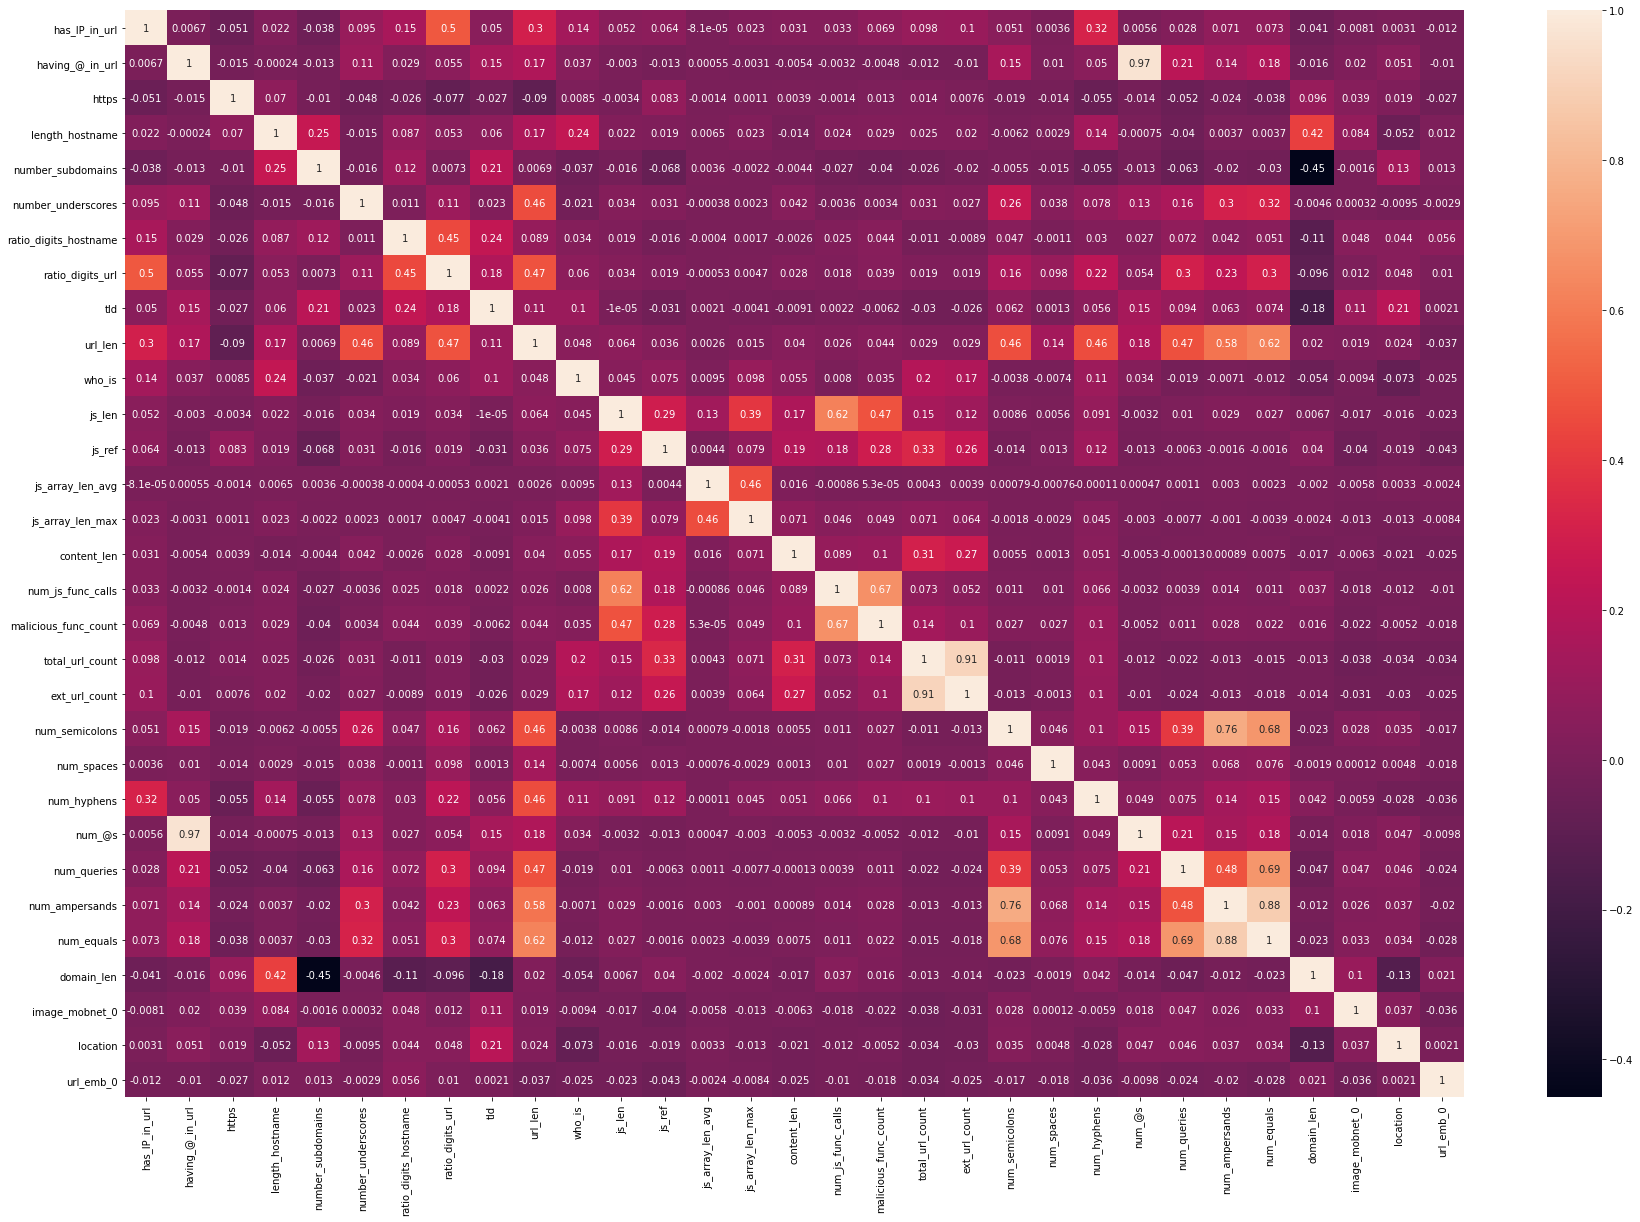

In [248]:
import seaborn as sn

plt.subplots(figsize=(30,20))
corrMatrix = X.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [249]:
# def histogram_intersection(a, b):
#     v = np.minimum(a, b).sum().round(decimals=1)
#     return v

# X.corr(method=histogram_intersection)

## Feature Selection - Chi Squared

In [250]:
X_new = SelectKBest(chi2, k=8).fit_transform(X, y)
X_new.shape

(105485, 8)

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

### XGBoost

In [252]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train)

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[10:20:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [253]:
y_pred = xgboost_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7885725776335066

In [254]:
confusion_matrix(y_test, y_pred)

array([[18088,  2192],
       [ 5168,  9363]])

In [255]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.7778    0.8919    0.8309     20280
   malicious     0.8103    0.6443    0.7179     14531

    accuracy                         0.7886     34811
   macro avg     0.7940    0.7681    0.7744     34811
weighted avg     0.7914    0.7886    0.7837     34811



## Correlation Feature Selection

In [256]:
len(X.columns)

31

In [257]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X, y, 55)
print(str(len(cor_feature)), 'selected features')
print(' ')
print(cor_feature)

31 selected features
 
['js_array_len_max', 'content_len', 'ext_url_count', 'js_array_len_avg', 'total_url_count', 'number_subdomains', 'https', 'domain_len', 'js_ref', 'who_is', 'num_spaces', 'malicious_func_count', 'num_js_func_calls', 'js_len', 'length_hostname', 'url_emb_0', 'number_underscores', 'num_semicolons', 'num_@s', 'having_@_in_url', 'num_ampersands', 'has_IP_in_url', 'ratio_digits_hostname', 'num_equals', 'location', 'num_hyphens', 'num_queries', 'ratio_digits_url', 'tld', 'image_mobnet_0', 'url_len']


In [258]:
X_train, X_test, y_train, y_test = train_test_split(X[cor_feature], y, test_size=0.33, random_state=42)

In [259]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train)

[10:20:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [260]:
y_pred = xgboost_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8199132458131051

In [261]:
confusion_matrix(y_test, y_pred)

array([[18294,  1986],
       [ 4283, 10248]])

In [262]:
print(classification_report(y_test, y_pred, 
                            target_names=['benign', 'malicious'], 
                            digits=4))

              precision    recall  f1-score   support

      benign     0.8103    0.9021    0.8537     20280
   malicious     0.8377    0.7053    0.7658     14531

    accuracy                         0.8199     34811
   macro avg     0.8240    0.8037    0.8097     34811
weighted avg     0.8217    0.8199    0.8170     34811

